In [1]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt  
from pylab import plt
plt.style.use('ggplot')

%matplotlib inline



### Reading data and sorting

We read our csv and sort by platenumber/bike_id and then by date.

In [2]:
path = '../../ebikes/data/finaldata/scoot_data.csv'
df = pd.read_csv(path)



In [7]:
df= df.sort_values(['id','date'], ascending=[True,True]) 

In [9]:
df.head()

,date,id,lat,lon,charge,type
21,2018-09-27 04:52:00,1,41.415217,2.204912,100.0,scooter
632,2018-09-27 04:57:00,1,41.415217,2.204912,100.0,scooter
1269,2018-09-27 05:02:00,1,41.415150,2.204998,100.0,scooter
1892,2018-09-27 05:07:00,1,41.415150,2.204998,100.0,scooter
2520,2018-09-27 05:12:00,1,41.415150,2.204998,100.0,scooter


In [8]:
#We'll be working on a copy of the dataframe
dftest = df

#### Verifying Number of bikes


In [10]:
dftest['id'].nunique()

938

In [11]:
dftest.describe()

,id,lat,lon,charge
count,1.013186e+06,1.013186e+06,1.013186e+06,1.013186e+06
mean,1.311129e+03,4.117506e+01,2.160026e+00,5.977555e+01
std,5.134973e+02,3.045277e+00,1.667275e-01,2.690819e+01
min,1.000000e+00,0.000000e+00,-3.639443e+00,0.000000e+00
25%,1.130000e+03,4.138354e+01,2.150245e+00,3.671000e+01
50%,1.416000e+03,4.140248e+01,2.179771e+00,6.155000e+01
75%,1.686000e+03,4.141516e+01,2.193887e+00,8.326000e+01
max,1.972000e+03,4.179355e+01,1.446258e+01,1.000000e+02


In [ ]:
dftest.head()

### Export clean data to CARTO

We create a new dataframe (bike1) to store only relevant data for exporting and visualizing in CARTO.

In [12]:
bike_carto = df.loc[:, ['date', 'lat', 'lon', 'id']]

In [ ]:
bike_carto.head()

In [13]:
import cartoframes
from cartoframes import Layer, BaseMap, styling

BASE_URL = 'https://pggmrt.carto.com'
API_KEY = 'XXXXXXXXXXXXXX'

cc = cartoframes.CartoContext(base_url=BASE_URL,
                              api_key=API_KEY)

cc.write(bike_carto, 'bikes_data')

#cc.map(Layer('bikes_data', time='date', color='net'))




### Heat map

Extract from an animated heatmap over the course of a 3 days.
Full interactive map available at https://pggmrt.carto.com

![Animated](../CARTO_imgs/scoot-heatmap.gif)


### K-means Clustering

Using CARTO we can perform a spatial clustering analysis that could be used to optimize and divide properly the city into a determined number of zones for each employee in charge of charging the bikes.

CARTO's clustering algorithm is based in PostGIS k-means and ST_ClusterKMeans functions.



![Still](../CARTO_imgs/5clusters.png)

## Analysis 
### Latitude/Longitude Delta

Adding two new columns to our dataframe with the latitude and longitude variation from previous timeframe with the shift method. We then fill the NaN values with 0 .



In [14]:
#biketest = bike1
diff_lat = dftest['lat'] - dftest['lat'].shift(1)

diff_lon = dftest['lon'] - dftest['lon'].shift(1)


dftest['lat_diff'] = diff_lat
dftest['lon_diff'] = diff_lon

# We Fill NaN values resulting from the shift
dftest.fillna(value=0, inplace=True)
dftest.head()

,date,id,lat,lon,charge,type,lat_diff,lon_diff
21,2018-09-27 04:52:00,1,41.415217,2.204912,100.0,scooter,0.000000,0.000000
632,2018-09-27 04:57:00,1,41.415217,2.204912,100.0,scooter,0.000000,0.000000
1269,2018-09-27 05:02:00,1,41.415150,2.204998,100.0,scooter,-0.000067,0.000087
1892,2018-09-27 05:07:00,1,41.415150,2.204998,100.0,scooter,0.000000,0.000000
2520,2018-09-27 05:12:00,1,41.415150,2.204998,100.0,scooter,0.000000,0.000000


### Finding number of rides based on Geodata

We are trying to estimate the number of rides taken by each bike, we will filter out those rows where the latitude or longitude changed substantially from the previous row (aka position change in the timeframe of 5 mins)

In order to do that we need to find a threshold of latitude and longitude variation as we can get slightly different geoposition lectures from bikes that are currently parked and not moving.
 
#### Degrees - meters conversion table

| degrees [º] | distance [m]  |
|-------------|---------------|
| 0.01        | 1110          |
| 0.001       | 111           |
| 0.0001      | 11.1          |
| 0.00001     | 1.11          |

#### Estimations

Mean GPS error on open sky has been said by ION and the US government to be between 4.9 and 5 meters. 

However we must take into consideration the vast amount of interferences a GPS device is under in an urban environment like Barcelona. 
Following the study by the University of Applied Sciences Zittau, Germany a positional error of 28 meters should be assumed in any location-based application. 

#### Threshold

28 meters = 0.000252º

#### References
- [Institute of Navigation](https://www.ion.org/publications/abstract.cfm?articleID=13079)
- [Official U.S. Government Global Positioning System Information](https://www.gps.gov/systems/gps/performance/accuracy/)
- [Field trial on GPS Accuracy in a medium size city: The influence of built-up, University of Applied Sciences Zittau/Görlitz, Germany](http://wpnc.net/fileadmin/WPNC06/Proceedings/30_Field_trial_on_GPS_Accuracy_in_a_medium_size_city_The_influence_of_builtup.pdf)



#### Find number of rides lasting 1 timeframe (5mins)

In [15]:
moves_t = diff_lat[((abs(dftest['lat_diff']) > 0.000252) | (abs(dftest['lon_diff']) > 0.000252) ) ].count()
print ('The number of rides is: ',moves_t)

The number of rides is:  64351


#### Shift() method fixing. 

Shift function creates a false positive with the first row of every new bike_id or plate number. 
We fix it by counting every row where the difference between the two rows (regular vs shift row) is greater than our threshold as well as the bike_id/plate is the same as the shifted row. 


In [19]:
moves_1t = dftest[((abs(dftest['lat_diff']) > 0.000252) | (abs(dftest['lon_diff']) > 0.000252) ) & (dftest['id'] == dftest['id'].shift(1) )].count()
print ('The  number of 5mins rides is: ', moves_1t[0])
#movesdf = dftest[(abs(dftest['lat_diff']) > 0.000252) & (dftest['plate'] == dftest['plate'].shift(1) )]

The  number of 5mins rides is:  63414


#### Calculate rides 2 timeframes (10mins) long

In [21]:
moves_2t = dftest[((abs(dftest['lat_diff']) > 0.000252) | (abs(dftest['lon_diff']) > 0.000252) ) & (dftest['lat_diff'].shift(1)> 0.000252)  & (dftest['id'] == dftest['id'].shift(1))].count()
print('The  number of 10mins rides is: ',moves_2t[0])

The  number of 10mins rides is:  1438


#### Calculate rides 3 timeframes (15mins) long

In [22]:
moves_3t = dftest[((abs(dftest['lat_diff']) > 0.000252) | (abs(dftest['lon_diff']) > 0.000252) ) & (dftest['lat_diff'].shift(1)> 0.000252)& (dftest['lat_diff'].shift(2)> 0.000252) & (dftest['id'] == dftest['id'].shift(1))].count()
print('The  number of 15mins rides is: ',moves_3t[0])

The  number of 15mins rides is:  73


#### Calculate rides 4 timeframes (20mins) long

In [24]:
moves_4t = dftest[((abs(dftest['lat_diff']) > 0.000252) | (abs(dftest['lon_diff']) > 0.000252) ) & (dftest['lat_diff'].shift(1)> 0.000252)& (dftest['lat_diff'].shift(2)> 0.000252) & (dftest['lat_diff'].shift(3)> 0.000252)  & (dftest['id'] == dftest['id'].shift(1))].count()
print('The  number of 20mins rides: ',moves_4t[0])

The  number of 20mins rides:  8


### Plotting estimate revenue + average minute ride

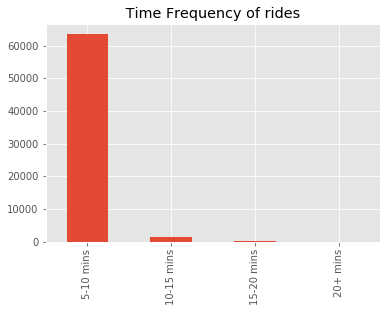

In [26]:
dfminutes = pd.DataFrame({'5-10 mins': [moves_1t[0]], '10-15 mins': [moves_2t[0]],'15-20 mins': [moves_3t[0]],'20+ mins': [moves_4t[0]], })
dfminutes = dfminutes[['5-10 mins', '10-15 mins', '15-20 mins', '20+ mins']].transpose()
dfminutes.plot(kind='bar', title=' Time Frequency of rides ', legend=False)
#ADD SCATTER REVENUE /CANDLESTICK MAX MIN MINUTES
#dfminutes.plot()

### Frequency and Timespan
We convert our date/time string into a Pandas datetime Timestamp

In [27]:
dftest['datetime'] = pd.to_datetime(dftest['date'])
dftest.head()

,date,id,lat,lon,charge,type,lat_diff,lon_diff,datetime
21,2018-09-27 04:52:00,1,41.415217,2.204912,100.0,scooter,0.000000,0.000000,2018-09-27 04:52:00
632,2018-09-27 04:57:00,1,41.415217,2.204912,100.0,scooter,0.000000,0.000000,2018-09-27 04:57:00
1269,2018-09-27 05:02:00,1,41.415150,2.204998,100.0,scooter,-0.000067,0.000087,2018-09-27 05:02:00
1892,2018-09-27 05:07:00,1,41.415150,2.204998,100.0,scooter,0.000000,0.000000,2018-09-27 05:07:00
2520,2018-09-27 05:12:00,1,41.415150,2.204998,100.0,scooter,0.000000,0.000000,2018-09-27 05:12:00


In [28]:
print('Data from ',dftest['datetime'][len(dftest)-1] - dftest['datetime'][34])

Data from  6 days 12:21:00


We then create a new dataframe only containing the rows representing each ride.

In [30]:
dfrides = dftest[((abs(dftest['lat_diff']) > 0.000252) | (abs(dftest['lon_diff']) > 0.000252) ) & (dftest['id'] == dftest['id'].shift(1) )]

We add a day of the week column to our rides datframe for further analysis

In [31]:
dfrides['dayofweek'] = dfrides['datetime'].dt.day_name()

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [32]:
dfrides.head()

,date,id,lat,lon,charge,type,lat_diff,lon_diff,datetime,dayofweek
11887,2018-09-27 06:33:00,1,41.415385,2.204975,100.00,scooter,0.000287,-0.000027,2018-09-27 06:33:00,Thursday
22284,2018-09-27 08:09:00,1,41.406522,2.194113,98.61,scooter,-0.008785,-0.010943,2018-09-27 08:09:00,Thursday
25293,2018-09-27 08:35:00,1,41.416180,2.206153,95.83,scooter,0.009657,0.012047,2018-09-27 08:35:00,Thursday
40402,2018-09-27 10:41:00,1,41.416348,2.206160,95.83,scooter,0.000270,0.000015,2018-09-27 10:41:00,Thursday
65860,2018-09-27 14:24:00,1,41.388733,2.172113,87.50,scooter,-0.027448,-0.033883,2018-09-27 14:24:00,Thursday


#### Hourly Rides

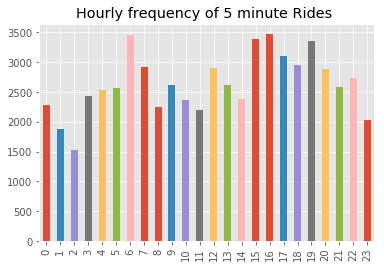

In [33]:
hourly = dfrides['datetime'].dt.hour.value_counts().sort_index().plot(kind='bar', title='Hourly frequency of 5 minute Rides ')

#### Weekly Rides

In [34]:
weekly = dfrides['dayofweek'].value_counts(sort=False)


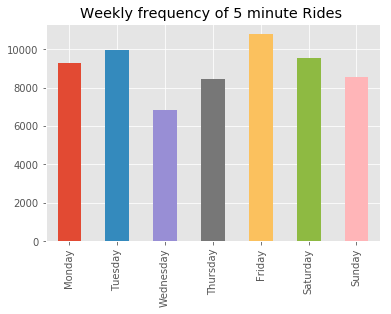

In [35]:
weekly =weekly.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
weekly.plot(kind='bar', title='Weekly frequency of 5 minute Rides ')